In [70]:
import pandas as pd
import pyarrow as pa
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [71]:
tqdm.pandas()

In [101]:
df = pd.read_csv(
    'urban-dictionary-words-dataset.zip', 
    error_bad_lines=False,
    usecols=[
        'word_id', 
        'word', 
        'up_votes',
        'down_votes',
        'definition']
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
df.shape

(2580925, 5)

In [103]:
df.up_votes = pd.to_numeric(df.up_votes, errors='coerce')
df.down_votes = pd.to_numeric(df.down_votes, errors='coerce')
df = df.dropna()

In [110]:
df = df.drop(df[df['down_votes'] < 0 ].index)
df = df.drop(df[df['up_votes'] < 0 ].index)

In [112]:
def mean(row):
	s = row.up_votes + row.down_votes
	r = row.up_votes
	return 0 if s == 0 else (r / s)

df['score'] = df.progress_apply(lambda row: mean(row), axis=1)

100%|██████████| 2578971/2578971 [02:47<00:00, 15369.67it/s]


In [121]:
df = df.drop(df[df['score'] < 0.5 ].index)
df['score'] = df.progress_apply(lambda row: (row.score - 0.5) / 0.5, axis=1)

100%|██████████| 1638633/1638633 [00:43<00:00, 37589.11it/s]


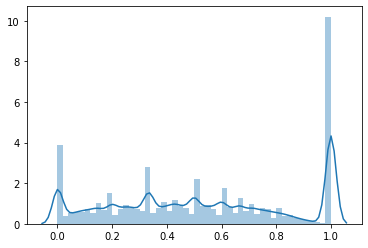

In [122]:
sns.distplot(df[['score']])

In [ ]:
#duplicates = df[df.duplicated(['word'], keep=False)]
#df[df['word'] == word][df['up_votes'] == df[df['word'] == word]['up_votes'].max()]

In [160]:
df = df.sort_values(by=['up_votes'], ascending=False)
df = df.drop_duplicates('word', keep='first')
df = df.sort_values(by=['score'], ascending=False)
df[df['up_votes'] > 1000][:20]

,word_id,word,up_votes,down_votes,definition,score
2407166,7731747,yofam,2067.0,0.0,Yofam is a greeting from one person to another...,1.000000
2304713,7070316,Taffanaut,1585.0,0.0,Person born in Wales (UK) who has travelled in...,1.000000
2333780,7219861,Thanksgivukkah,3860.0,2.0,Thanksgivukkah is the name given to the conver...,0.998964
2404274,7705693,seachellefly,4140.0,6.0,"A cheating, conniving, lying person of the fem...",0.997106
2441596,7905086,Wisdom Bomb,1106.0,2.0,Sage advice given.,0.996390
2467497,8033884,rateboost,1028.0,2.0,To dishonestly boost your rates for personal g...,0.996117
2209209,6466831,transpants,4408.0,9.0,Pants designed for the female figure that add ...,0.995925
2367803,7431915,lady giblets,1773.0,4.0,Female reproductive organs.,0.995498
2266389,6851605,SigEp Saddle,1277.0,3.0,The name given to a sorostitute/slam-piece tha...,0.995313
2217637,6523029,Social Securitits,1583.0,4.0,Women over the age of 55 who refuse to wear a ...,0.994959


In [173]:
df['pat'] = df['score'].apply(lambda s: round(s, 1))

In [174]:
df.to_parquet('output', engine='pyarrow', partition_cols = ['pat'])